In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.training import split_participants
from hmpai.pytorch.utilities import set_global_seed
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.pytorch.normalization import *
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.pytorch.training import train_and_test
from tqdm.notebook import tqdm
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
# Load in t1, t2 and cmb
t1_path = DATA_PATH / "prp/stage_data_250hz_t1.nc"
t2_path = DATA_PATH / "prp/stage_data_250hz_t2.nc"
cmb_path = DATA_PATH / "prp/data_t_250hz.nc"

t1 = xr.open_dataset(t1_path)
t2 = xr.open_dataset(t2_path)
cmb = xr.open_dataset(cmb_path)

In [3]:
# (participant[t1], epochs[cmb], labels[t1 + t2 - 1], samples[cmb])
# labels[0,:] should be 0, will be filled later
cmb_proba = np.zeros(
    (
        t1.probabilities.shape[0],
        cmb.data.shape[1],
        t1.probabilities.shape[2] + t2.probabilities.shape[2] - 1,
        cmb.data.shape[3],
    )
)
# For each trial_index (0 > 1315)
for i in tqdm(range(int(cmb.trial_index.max().item()) + 1)):
    i = float(i)
    # For each participant
    for j in range(len(cmb.participant)):
        t1_data = t1.isel(participant=[j])
        t2_data = t2.isel(participant=[j])
        cmb_data = cmb.isel(participant=[j])

        if (
            i not in t1_data.trial_index.values
            or i not in t2_data.trial_index.values
            or i not in cmb_data.trial_index.values
        ):
            # print(f"Participant {j} does not have trial {i} in t1, t2 or cmb")
            continue

        t1_data = t1_data.where(t1_data.trial_index == i, drop=True)
        t2_data = t2_data.where(t2_data.trial_index == i, drop=True)
        cmb_data = cmb_data.where(cmb_data.trial_index == i, drop=True)
        if (
            not t1_data.condition.item()
            == t2_data.condition.item()
            == cmb_data.condition.item()
        ):
            print(
                f"Participant {j} has different conditions for t1 and t2: {t1_data.condition.item()} vs {t2_data.condition.item()}"
            )
            break
        cmb_epoch = cmb_data.epochs.values.item()
        t1_proba = t1_data.probabilities.values
        t2_proba = t2_data.probabilities.values

        # Since offset_before is the same, this should work, start + 62 is stim T1
        cmb_proba[j, cmb_epoch, 1 : t1_proba.shape[2], : t1_proba.shape[3]] = t1_proba[
            ..., 1:, :
        ]
        total_offset = int(
            t2_data.offset_before + (cmb_data.interval * cmb_data.sfreq).item()
        )

        t2_proba_subset = t2_proba[
            ...,
            1:,
            t2_data.offset_before : t2_data.offset_before
            + (cmb_proba.shape[3] - total_offset),
        ]

        # Pad with zeroes at end of samples if total_offset is small and t2 is too short
        if cmb_proba.shape[3] - total_offset > t2_proba_subset.shape[3]:
            t2_proba_subset = np.pad(t2_proba_subset, ((0, 0), (0, 0), (0, 0), (0, (cmb_proba.shape[3] - total_offset) - t2_proba_subset.shape[3])))

        cmb_proba[
            j,
            cmb_epoch,
            t1_proba.shape[2] : t1_proba.shape[2] + t2_proba.shape[2],
            total_offset : cmb_proba.shape[3],
        ] = t2_proba_subset

  0%|          | 0/1315 [00:00<?, ?it/s]

In [4]:
cmb = cmb.assign(probabilities=(('participant', 'epochs', 'labels', 'samples'), cmb_proba))

In [9]:
cmb.to_netcdf(DATA_PATH / "prp/stage_data_250hz_cmb.nc")

In [84]:
cmb_proba.shape

(21, 1280, 7, 637)

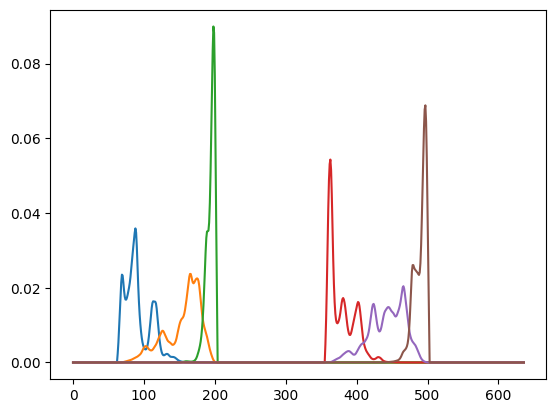

In [87]:
import matplotlib.pyplot as plt
for i in range(cmb_proba.shape[2]):
    if i == 0:
        continue
    plt.plot(cmb_proba[0, 100, i, :])